In [1]:
import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

# set parameters:
maxlen = 400

def read_file(filename = '../datasets/hs_train.csv', maxlen = 0, tokenizer = None, noLabels = False):
    dataset = pd.read_csv(filename)
    X0 = dataset['text']
    if (noLabels == False):
        y = dataset['labels']
    else:
        y = None
    if (tokenizer is None):
        t = Tokenizer()
        t.fit_on_texts(X0) 
    else:
        t = tokenizer;
        
    X1 = t.texts_to_sequences(X0)
    X = sequence.pad_sequences(X1, maxlen=maxlen)
    return X, y, t


def get_glove_embedding(maxlen = maxlen):
    BASE_DIR = '../datasets'
    GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
    MAX_NUM_WORDS = 30000
    EMBEDDING_DIM = 100

    # first, build index mapping words in the embeddings set
    # to their embedding vector

    print('Indexing word vectors.')

    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    X, y, tokenizer = read_file(maxlen = maxlen)

    #print('Found %s texts.' % len(texts))

    # finally, vectorize the text samples into a 2D integer tensor

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    print('Shape of data tensor:', X.shape)
    print('Shape of label tensor:', y.shape)


    print('Preparing embedding matrix.')

    # prepare embedding matrix
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=maxlen,
                                trainable=False)
    
    return X, y, tokenizer, embedding_layer




Using TensorFlow backend.


In [2]:
from __future__ import print_function

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from keras.initializers import Constant



print('Loading data...')
#X, y, tokenizer = read_training_file(maxlen = maxlen)
X, y, tokenizer, embedding_layer = get_glove_embedding(maxlen)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

vocab_size = len(tokenizer.word_index) + 1

Loading data...
Indexing word vectors.
Found 400000 word vectors.
Found 20215 unique tokens.
Shape of data tensor: (5266, 400)
Shape of label tensor: (5266,)
Preparing embedding matrix.
4212 train sequences
1054 test sequences
x_train shape: (4212, 400)
x_test shape: (1054, 400)


In [3]:
print(vocab_size)

20216


In [4]:
batch_size = 32
filters = 256
kernel_size = 4
hidden_dims = 128
epochs = 5

print('Build model...')
model = Sequential()

model.add(embedding_layer)

model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(MaxPooling1D())

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',
              #optimizer='adam',
              optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          2021600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 397, 256)          102656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 256)          262400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


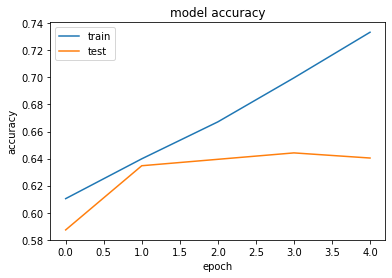

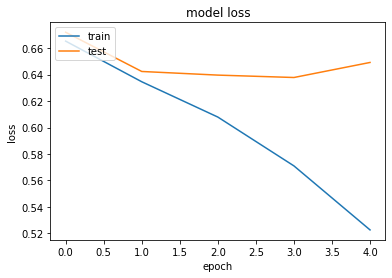

In [5]:
import matplotlib.pyplot as plt

def show_history_regression(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def show_history_classification(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_history_classification(history)

In [6]:
testX, y, tokenizer = read_file(filename = '../datasets/hs_test.csv', 
                                maxlen = maxlen, 
                                tokenizer = tokenizer, 
                                noLabels = True)

predicted_labels = model.predict_classes(testX)

wfile = open('hs_testout_keras.csv', 'w', encoding="utf-8")
wfile.write("labels\n")
for i in range(len(predicted_labels)):
    wstring = str(predicted_labels.reshape(-1)[i]) + '\n'
    wfile.write(wstring)

wfile.close()


In [7]:
print(predicted_labels.shape)


(586, 1)


In [8]:
print(predicted_labels.reshape(-1)[0])

1
